## Project: Analyze A/B Test Results
### Author: Samuel Carleial


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
# Modules
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm

# Magic functions
%matplotlib inline

# Set the seed to assure getting the correct answers on quizzes
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset:

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset:

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted:

In [5]:
# mean true convertion (by user)
df.groupby('user_id')['converted'].mean().mean()

0.1195557910965504

In [6]:
# overall mean convertion (whole dataset)
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up:

In [7]:
# Python: get a frequency count based on two columns (variables) in pandas dataframe
# code source: https://stackoverflow.com/questions/33271098/python-get-a-frequency-count-based-on-two-columns-variables-in-pandas-datafra
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [8]:
# I believe it is meant the number of times we get unexpected results 
# (i.e., control click on new page and experiment on old page)
# In this case, we have: 
1928 + 1965

3893

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
# check any missing value and return the row that missing value is in
# code source: https://stackoverflow.com/questions/30447083/python-pandas-return-only-those-rows-which-have-missing-values
df[df.isnull().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [12]:
# Double-check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2['user_id'].value_counts().head(1)

773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2 = df2.drop_duplicates()

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
round(df2['converted'].mean(), 4)

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
round(df2.query('group == "control"')['converted'].mean(), 4)

0.1204

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
round(df2.query('group == "treatment"')['converted'].mean(), 4)

0.1188

d. What is the probability that an individual received the new page?

In [20]:
df2['landing_page'].value_counts('new_page')

new_page    0.500064
old_page    0.499936
Name: landing_page, dtype: float64

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**My answer: <br> We observe that in this dataset virtually half of the individuals received the old page, whereas the other half received the new page. The probability of converting (mean conversion) from these two subgroups is the same, i.e. 12%. Thus, we don't have strong reasons to believe that one or the other type of page leads to more conversions. Besides, it is a farily large number of samples involved (about 30k individual observations), which reasonably supports this conclusion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the timestamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**My answer:<br> The null hypothesis ($H_0$) should defend that the old page is so good as or even better that the new page. The alternative hypothesis ($H_1$) should, in turn, be the one that says that the new page performs better than the old one in terms of conversion rates. Putting this information into notation:<br><br> $$H_0: p_{new} - p_{old} \leq 0 $$ $$H_1: p_{new} - p_{old} > 0$$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
pnew = df2['converted'].mean()
pnew

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null?

In [22]:
pold = df2['converted'].mean()
pold

0.11959667567149027

c. What is $n_{new}$?

In [23]:
nnew = df2.query('landing_page == "new_page"').shape[0]
nnew

145311

d. What is $n_{old}$?

In [24]:
nold = df2.query('landing_page == "old_page"').shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(1, pnew, nnew)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1, pold, nold)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.000918285431036267

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []
for i in range(10000):
    temp_p_new = np.random.binomial(1, pnew, nnew)
    temp_p_old = np.random.binomial(1, pold, nold)
    p_diffs.append(temp_p_new.mean() - temp_p_old.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?<br>  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [29]:
# Actual difference in the dataset between new and old page conversion rates:
# Since group and landing page are matched, we can choose one of the two variables to look at page (new vs. old) convertion
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diff

-0.0015790565976871451

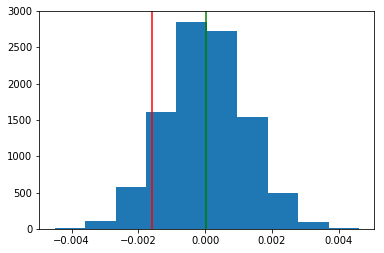

In [30]:
plt.hist(p_diffs)
plt.axvline(x = actual_diff, color = 'red') # actual difference in the dataset
plt.axvline(x = np.mean(p_diffs), color = 'green'); # mean difference in simulation

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
np.mean([np.array(p_diffs) > actual_diff])

0.9106

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**My answer:<br> The computed estimate in part **j** is the threshold value which can determine whether we keep the null hypothesis, or, alternatively, reject it and accept the alternative hypothesis. In other words, the p-value. Since in this case we observe a relatively high p-value (0.907) we cannot reject the null hypothesis. Hence, the conversion rate for the new page is not greater than the one for the old page, or at least they may be the same. After comparing our actual result with the 10,000 simulations we can only assure that the new page is just as good or maybe even worse than the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the number of rows associated with the old page and new pages, respectively.

In [32]:
convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = nold
n_new = nnew

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest(count = [convert_new, convert_old], nobs = [n_new, n_old], alternative = 'larger')
print("z score:", z_score)
print("p-value:", p_value)

z score: -1.3116075339133115
p-value: 0.905173705140591


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?<br>  Do they agree with the findings in parts **j.** and **k.**?

**My answer:<br> Using the built-in function from the scipy package we notice that the p-value is very close to the one found in the previous item (ca. 0.9). To compare this function with the previous item, I also used the same hypothesis testing comparison of $p_{new}$ being larger than $p_{old}$. Additionally, the **z**-score shows that in average the old page happens to have more clicks than the new page, since **z** is negative. In my opinion, the results from this function are in accord with the previous results in parts **j** and **k**.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**My answer: logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.**, to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2['ab_page'] = np.where(df2['group'] == 'control', 0, 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
# Instantiate and fit the logistic regression:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Jun 2018   Pseudo R-squ.:               8.085e-06
Time:                        16:36:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?

**My answer:<br> The p-value in my logistic regression for the effect of "ab_page" is 0.190. The reason I found this p-value to be different from the one I calculated previously is because the hypothesis here is also different from that another test. The hypothesis being tested here with my logistic model is "two-sided", meaning that $p_{new}$ is greater or lower than $p_{old}$. In other words, $p_{old}$ and $p_{new}$ are different. Previously, I tested whether the $p_{new}$ was specifically greater than $p_{old}$.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**My answer:<br> Other factors which were not included in the model might better explain the variation in page conversion. When we include more variables in a model we make a model more complex, reducing the degrees of freedom. This has both advantages and disadvantages. In one hand, we might better explain the variation in our dependent variable, but on the other hand the model might not be as robust as before, because reducing degrees of freedom also reduces the capability of fitting the data into our model algorithm. Additionally, chances are that the more variables we include in a model we might happen to find false positives and incur into type I errors. Thus, we must be really sure which variables we need to include in a model, based on previous experience or some theoretical basis.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# Import the dataset with additional information:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# Join datasets:
# Notice that both datasets (df2 and countries) can be merged using "user_id" as a key
df3 = df2.join(countries.set_index('user_id'), on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
# Let's shortly check whether the new dataset is ok or have NAs:
df3[df3.isnull().any(axis=1)]

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country


In [40]:
# How many levels in "country" there are? This will determine which dummy variables we should create:
df3['country'].value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

In [41]:
# Add dummy variables to the dataset:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [42]:
# Instantiate and fit the new logistic regression:
model2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
result2 = model2.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [43]:
# Summary of the new model:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Jun 2018   Pseudo R-squ.:               2.324e-05
Time:                        16:36:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

In [44]:
# Interpretations:
print("Country CA to US:", (1/np.exp(-0.0408)).round(2))
print("Country UK to US:", np.exp(-1.3387).round(2))

Country CA to US: 1.04
Country UK to US: 0.26


**My answer:<br> The new model (model2) included the extra effect of country masked as dummy variables. Judging by the model2 summary output, I think the effect of country does not add much to explaining the variation in page conversion. The pseudo r-square is a bit better (one decimal unit larger), but the effects of each country are not significant. Besides, their coefficients seem to low. If we convert the coefficient from log to a better representation there seem to be a difference between individuals from CA and US by a factor of 1.04. However, as mentioned before these estimates are not significant. Therefore, I don't see a reason to believe that "country" has a strong impact on the page conversion rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
# Create interactions:
df3['ab_pagexCA'] = df3['ab_page']*df3['CA']
df3['ab_pagexUK'] = df3['ab_page']*df3['UK']
df3['ab_pagexUS'] = df3['ab_page']*df3['US']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_pagexCA,ab_pagexUK,ab_pagexUS
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [46]:
# Instantiate and fit a logistic regression with interaction factors (US is the reference):
model3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'ab_pagexCA', 'ab_pagexUK']])
result3 = model3.fit()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


In [47]:
# Summary of the new model:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Jun 2018   Pseudo R-squ.:               3.483e-05
Time:                        16:36:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.506      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_pagexCA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_pagexUK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**My answer:<br> Again, we notice a very slight improvement in the model fit by looking at the pseudo R-square. However, when we look at the coefficients from the explanatory variables (main effects and interactions), we observe that none of them are significant. Thus, using this new model (model3), does not give us support to believe that country, web-page or their interaction (the different effects of country of origin for the individual and the page they received) significantly explain the variation in page conversion. So, we still don't have evidence that the new page is better than the old one.**

i. Additional analysis. 

* Let's also include time in the analysis, namely hour, weekday, month and year.
* Then, let's select the model in which only significant variables were detected.
* Finally, let's visualize how page conversion relates significantly with (if any) explanatory variables.

In [48]:
# Set 'timestamp' as a datetime variable:
df3['timestamp'] = pd.to_datetime(df3['timestamp'])

# Create the time variables:
df3['hour'] = df3['timestamp'].dt.hour
df3['weekday'] = df3['timestamp'].dt.dayofweek
df3['month'] = df3['timestamp'].dt.month
df3['year'] = df3['timestamp'].dt.year

# Check new variables:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_pagexCA,ab_pagexUK,ab_pagexUS,hour,weekday,month,year
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0,22,5,1,2017
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0,8,3,1,2017
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1,16,2,1,2017
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1,18,6,1,2017
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0,1,5,1,2017


In [49]:
# See how time variables change and whether they can be used in a model:
df3[['hour', 'weekday', 'month', 'year']].describe()

,hour,weekday,month,year
count,290585.000000,290585.000000,290585.0,290585.0
mean,11.506354,2.891701,1.0,2017.0
std,6.919712,2.024723,0.0,0.0
min,0.000000,0.000000,1.0,2017.0
25%,6.000000,1.000000,1.0,2017.0
50%,12.000000,3.000000,1.0,2017.0
75%,17.000000,5.000000,1.0,2017.0
max,23.000000,6.000000,1.0,2017.0


Notice that only hour and weekday have enough variation

In [50]:
# Check whether hour and weekday are correlated:
# This is to assure our model assumption is respected (independent x variables)

# How to get correlation of two vectors in python
# source code: https://stackoverflow.com/questions/19428029/how-to-get-correlation-of-two-vectors-in-python
np.corrcoef(df3['hour'], df3['weekday'])

array([[ 1.        , -0.00610259],
       [-0.00610259,  1.        ]])

Correlation coefficient between hour and weekday is very small (i.e., < 1%). Thus, we can use both in a new model fit.

In [51]:
# Fit another logistic regression:
# Now, let's include more variables to the model
model4 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'ab_pagexCA', 'ab_pagexUK', 'weekday', 'hour']])
result4 = model4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366094
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            7
Date:                Mon, 04 Jun 2018   Pseudo R-squ.:               7.382e-05
Time:                        16:36:30   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.02793
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0032      0.016   -126.358      0.000      -2.034      -1.972
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0174      0.038     -0.462      0.644      -0.091       0.056
UK            -0.0056      0.019     -0.300      0.764      -0.042       0.031
ab_pagexCA    -0.0468      0.054     -0.871      0.384      -0.152       0.059
ab_pagexUK     0.0315      0.027      1.183      0.237      -0.021       0.084
weekday       -0.0030      0.003     -1.078      0.281      -0.009       0.002
hour           0.0022      0.001      2.664      0.008       0.001       0.004
==============================================================================
"""

In [52]:
# Fit a final logistic regression:
# Now, let's include only significant variables and the main variable of interest for our hypothesis test ('ab_page')
model4 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'hour']])
result4 = model4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366105
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Jun 2018   Pseudo R-squ.:               4.159e-05
Time:                        16:36:32   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.01198
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0143      0.013   -160.898      0.000      -2.039      -1.990
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
hour           0.0022      0.001      2.670      0.008       0.001       0.004
==============================================================================
"""

Notice that the main interpretations that can be taken from the latest model, model4 above, do not change. In addition, we have now a more 'cleaner' model. The pseudo R-square actually did not drop much, suggesting that the other variables indeed were badly explaining variation in the conversion rate.

In [53]:
# How much does hour impact on page conversion:
# I.e., the effect of increase of hour per unit on page conversion
print("Hour of the day impact on page conversion:", np.exp(0.0022).round(2))

Hour of the day impact on page conversion: 1.0


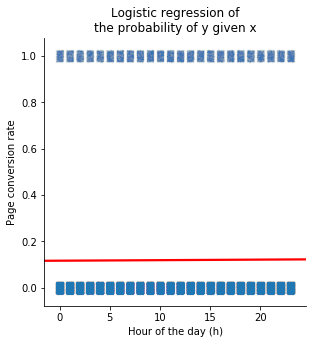

In [54]:
# Visualizing linear relationships
# source code: https://seaborn.pydata.org/tutorial/regression.html
sns.lmplot(x = "hour", y = "converted", data = df3, logistic = True,
           y_jitter = 0.025, x_jitter = 0.35, ci = None, n_boot = 10000, size = 4.5,
           scatter_kws = {'s': 0.1, 'alpha':0.05}, line_kws = {'color': 'red'})
plt.xlabel("Hour of the day (h)")
plt.ylabel("Page conversion rate")
plt.title("Logistic regression of\nthe probability of y given x");

Note that in the graph above we would like to visualize the positive relationship (that in the model output was significantly positive) between hour (the independent explanatory x variable) and page convertion (the dependent response y variable). The line show the trend, but the slope is really small, so the increase, although positive is very small. This suggests that hour does't have a really clear and strong effect on page conversion. 

**My answer:<br> The new model (model4) explained sligthly a bit more than the previous models, if we only look at the pseudo R-square value. Looking at each explanatory variable, we notice though that their coefficients are not significant, which is in accord with the previous models. However, when we observe the time variables, we see that the dataset actually only had observations for the month of January 2017. We may argue that this is actually a bit unrepresentative, since more trafick may occur in other months of the year. It can be that, depending on the type of e-commerce, more clients could buy products close to other days or festivities of the year, such as Christmas, Carnival, etc.
<br><br> If we assume nevertheless that this is ok, we may judge page conversion by the weekdays and time of the day (i.e., hour). Here we find that weekdays are not significant. On the other hand, hour is significant. That is, the latter in the day the more the new pages seem to be visited (positive relationship by a factor of 1). Although positive, the coefficient of increase seem to be very reduced (see graph above). If this difference had been really strong, than we could have considered actually having both types of page, and, dependendent on the hour, these pages could be differently accessible to clients online. 
<br><br>More data could be still gathered in different times of the year in order to allow for a better testing of the new page. This could allow testing the effect of different months, for example. A personalized approach dependent on time could in the end perform better than just deciding whether to stick with one or another page type. Still, time and costs might be first judged and a compromise should be met between investing on this test and implementing the changes. In my opinion, this should be decided beforehand.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [55]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0